In [1]:
from modules.base import *

#### Subgraph

- 그래프 내부에 그래프를 추가하여 복잡한 프로세스를 처리

---

In [2]:
class Log(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str
    grade: Optional[int]
    grader: Optional[str]
    feedback: Optional[str]

##### 1. Failure Analysis Subgraph

In [3]:
class FailureAnalysisState(TypedDict):
    cleaned_logs: List[Log]
    failures: List[Log]
    fa_summary: str
    processed_logs: List[str]

class FailureAnalysisOutputState(TypedDict):
    fa_summary: str
    processed_logs: List[str]

@trace_function(only_func_name=False, print_json_format=True)
def get_failures(state):
    cleaned_logs = state["cleaned_logs"]
    failures = [log for log in cleaned_logs if "grade" in log]
    return {"failures": failures}

@trace_function(only_func_name=False, print_json_format=True)
def generate_summary(state):
    failures = state["failures"]
    fa_summary = "Chroma 요청에 대한 내용을 조회하지 못했습니다." # 실제로 사용시 summarize node 추가 필요
    return {"fa_summary": fa_summary, "processed_logs": [f"failure-analysis-on-log-{failure['id']}" for failure in failures]}

fa_builder = StateGraph(input=FailureAnalysisState,output=FailureAnalysisOutputState)
fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)
fa_builder.add_edge(START, "get_failures")
fa_builder.add_edge("get_failures", "generate_summary")
fa_builder.add_edge("generate_summary", END)
graph = fa_builder.compile()

/tmp/ipykernel_3081269/1568694264.py:23: LangGraphDeprecationWarning: Initializing StateGraph without state_schema is deprecated. Please pass in an explicit state_schema instead of just an input and output schema.
  fa_builder = StateGraph(input=FailureAnalysisState,output=FailureAnalysisOutputState)


##### 2. Question Summarization Subgraph

In [4]:
# Summarization subgraph
class QuestionSummarizationState(TypedDict):
    cleaned_logs: List[Log]
    qs_summary: str
    report: str
    processed_logs: List[str]

class QuestionSummarizationOutputState(TypedDict):
    report: str
    processed_logs: List[str]

@trace_function(only_func_name=False, print_json_format=True)
def generate_summary(state):
    cleaned_logs = state["cleaned_logs"]
    summary = "사용자 요청은 Chroma 벡터 스토어 사용 방법에 대한 내용을 질문하고 있습니다." # 실제 사용시 summary node 추가 필요
    return {"qs_summary": summary, "processed_logs": [f"summary-on-log-{log['id']}" for log in cleaned_logs]}

@trace_function(only_func_name=False, print_json_format=True)
def send_to_slack(state):
    qs_summary = state["qs_summary"]
    # 실제 사용시 report node 추가 필요
    report = """### Report Summary

#### Cleaned Logs
1. **Question**: ChatOllama를 사용하려면 어떻게 해야하나요?  
   **Answer**: ChatOllama를 사용하려면 `from langchain_community.chat_models import ChatOllama`를 사용하세요.

2. **Question**: Chroma 벡터 스토어를 사용하려면 어떻게 해야하나요?  
   **Answer**: `rag_chain = create_retrieval_chain(retriever, question_answer_chain)`를 사용하세요.  
   **Grade**: 0 (Feedback: 조회한 데이터는 벡터 스토어에 대한 내용을 언급하지만, Chroma에 대한 내용은 없습니다.)

#### User Request Summary
- 사용자 요청: Chroma 벡터 스토어 사용 방법에 대한 질문.

#### Processed Logs
- `summary-on-log-1`
- `summary-on-log-2`"""
    return {"report": report}

qs_builder = StateGraph(input=QuestionSummarizationState,output=QuestionSummarizationOutputState)
qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)
qs_builder.add_edge(START, "generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", END)
graph = qs_builder.compile()

/tmp/ipykernel_3081269/4045862098.py:40: LangGraphDeprecationWarning: Initializing StateGraph without state_schema is deprecated. Please pass in an explicit state_schema instead of just an input and output schema.
  qs_builder = StateGraph(input=QuestionSummarizationState,output=QuestionSummarizationOutputState)


##### 3. Entry Graph (Main Graph)

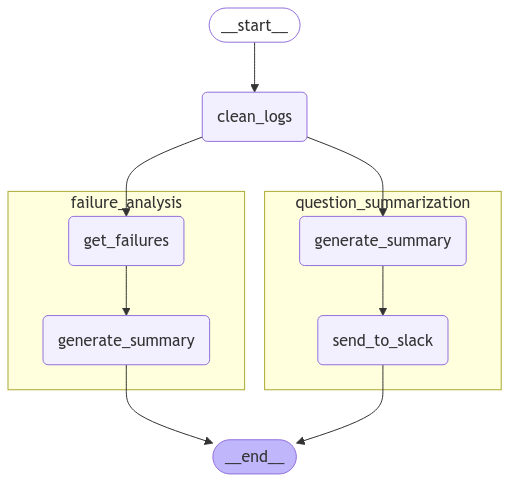

In [5]:
# Entry Graph
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: List[Log]
    fa_summary: str # This will only be generated in the FA sub-graph
    report: str # This will only be generated in the QS sub-graph
    processed_logs:  Annotated[List[int], add] # This will be generated in BOTH sub-graphs

@trace_function(only_func_name=False, print_json_format=True)
def clean_logs(state):
    # Get logs
    raw_logs = state["raw_logs"]
    # Data cleaning raw_logs -> docs 
    cleaned_logs = raw_logs
    return {"cleaned_logs": cleaned_logs}

entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("clean_logs", clean_logs)
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())

entry_builder.add_edge(START, "clean_logs")
entry_builder.add_edge("clean_logs", "failure_analysis")
entry_builder.add_edge("clean_logs", "question_summarization")
entry_builder.add_edge("failure_analysis", END)
entry_builder.add_edge("question_summarization", END)

graph = entry_builder.compile()

from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [6]:
# Dummy logs
question_answer = Log(
    id="1",
    question="ChatOllama를 사용하려면 어떻게 해야하나요?",
    answer="ChatOllama를 사용하려면 'from langchain_community.chat_models import ChatOllama'를 사용하세요.",
)

question_answer_feedback = Log(
    id="2",
    question="Chroma 벡터 스토어를 사용하려면 어떻게 해야하나요?",
    answer="Chroma 벡터 스토어를 사용하려면 'rag_chain = create_retrieval_chain(retriever, question_answer_chain)'를 사용하세요.",
    grade=0,
    grader="Document Relevance Recall",
    feedback="조회한 데이터는 벡터 스토어에 대한 내용을 언급하지만, Chroma에 대한 내용은 없습니다.",
)

raw_logs = [question_answer,question_answer_feedback]
graph.invoke({"raw_logs": raw_logs})


🚀 Passing Through [clean_logs] ..

#### [Input State]
args: [
    {
        "raw_logs": [
            {
                "id": "1",
                "question": "ChatOllama를 사용하려면 어떻게 해야하나요?",
                "answer": "ChatOllama를 사용하려면 'from langchain_community.chat_models import ChatOllama'를 사용하세요."
            },
            {
                "id": "2",
                "question": "Chroma 벡터 스토어를 사용하려면 어떻게 해야하나요?",
                "answer": "Chroma 벡터 스토어를 사용하려면 'rag_chain = create_retrieval_chain(retriever, question_answer_chain)'를 사용하세요.",
                "grade": "0",
                "grader": "Document Relevance Recall",
                "feedback": "조회한 데이터는 벡터 스토어에 대한 내용을 언급하지만, Chroma에 대한 내용은 없습니다."
            }
        ],
        "processed_logs": []
    }
]

#### [Output State]
result: {
    "cleaned_logs": [
        {
            "id": "1",
            "question": "ChatOllama를 사용하려면 어떻게 해야하나요?",
            "answer": "ChatOllama를 사용하려면 'from langchain_community.chat_models

{'raw_logs': [{'id': '1',
   'question': 'ChatOllama를 사용하려면 어떻게 해야하나요?',
   'answer': "ChatOllama를 사용하려면 'from langchain_community.chat_models import ChatOllama'를 사용하세요."},
  {'id': '2',
   'question': 'Chroma 벡터 스토어를 사용하려면 어떻게 해야하나요?',
   'answer': "Chroma 벡터 스토어를 사용하려면 'rag_chain = create_retrieval_chain(retriever, question_answer_chain)'를 사용하세요.",
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': '조회한 데이터는 벡터 스토어에 대한 내용을 언급하지만, Chroma에 대한 내용은 없습니다.'}],
 'cleaned_logs': [{'id': '1',
   'question': 'ChatOllama를 사용하려면 어떻게 해야하나요?',
   'answer': "ChatOllama를 사용하려면 'from langchain_community.chat_models import ChatOllama'를 사용하세요."},
  {'id': '2',
   'question': 'Chroma 벡터 스토어를 사용하려면 어떻게 해야하나요?',
   'answer': "Chroma 벡터 스토어를 사용하려면 'rag_chain = create_retrieval_chain(retriever, question_answer_chain)'를 사용하세요.",
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': '조회한 데이터는 벡터 스토어에 대한 내용을 언급하지만, Chroma에 대한 내용은 없습니다.'}],
 'fa_summary': 'Chroma 요청에 대한 내용